In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from mutabledataset import GermanSimDataset
from sklearn.preprocessing import MaxAbsScaler
from agent import RationalAgent, RationalAgentOrig
from simulation import Simulation
from learner import LogisticLearner
import plot
import numpy as np
import pandas as pd
from learner import StatisticalParityLogisticLearner, StatisticalParityFlipperLogisticLearner
from learner import FairLearnLearner
from learner import RandomForestLearner, MultinomialNBLearner
from learner import RejectOptionsLogisticLearner
from learner import ReweighingLogisticLearner
from IPython.display import display, Markdown, Latex
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.random import normal

sns.set()

Import error: No module named 'tensorflow'


## Parameters for simulation

In [2]:

immutable = ['age']

mutable_monotone_neg = ['month', 'credit_amount', 'status', 'investment_as_income_percentage', 'number_of_credits', 'people_liable_for']
mutable_dontknow = ['residence_since']
mutable_monotone_pos = ['savings']

categorical = ['credit_history=A34', 'purpose=A48','has_checking_account', 'purpose=A41', 'other_debtors=A103', 'purpose=A46', 'purpose=A40', 'credit_history=A31', 'employment=A74', 'credit_history=A30', 'credit_history=A33', 'purpose=A410', 'installment_plans=A143', 'housing=A153', 'property=A121', 'telephone=A192', 'skill_level=A171', 'purpose=A44', 'purpose=A45', 'housing=A152', 'other_debtors=A102', 'employment=A75', 'employment=A71', 'purpose=A43', 'property=A124', 'property=A123', 'housing=A151', 'employment=A72', 'credit_history=A32', 'property=A122', 'telephone=A191', 'installment_plans=A142', 'skill_level=A172', 'purpose=A42', 'employment=A73', 'other_debtors=A101', 'skill_level=A173', 'purpose=A49', 'installment_plans=A141', 'skill_level=A174']


mutable_attr = 'savings'
group_attr = 'age'
priv_classes = [lambda x: x >= 25]

privileged_group = {group_attr: 1}
unprivileged_group = {group_attr: 0}
DefaultAgent = RationalAgentOrig #RationalAgent, RationalAgentOrig (approx b(x) = h(x))

cost_fixed = lambda size: np.abs(np.random.normal(loc=0.5,scale=0.5,size=size))
# TODO: plot cost function for dataset

C = 0.1

all_mutable = mutable_monotone_pos + mutable_monotone_neg + mutable_dontknow + categorical
c_pos = lambda x_new, x, rank: np.clip((rank(x_new)-rank(x))/len(all_mutable), 0., None)
c_neg = lambda x_new, x, rank: np.clip((rank(x)-rank(x_new))/len(all_mutable), 0., None)
c_cat = lambda x_new, x, rank: (C/len(all_mutable))
c_immutable = lambda x_new, x, rank: np.abs(x_new-x)*np.nan_to_num(float('inf'))


print(len(all_mutable))




48


## Common simulation code

In [3]:

def dataset():
    return GermanSimDataset(mutable_features=all_mutable,
            domains={k: 'auto' for k in all_mutable},
                         discrete=all_mutable,
                         protected_attribute_names=[group_attr],
                         cost_fns={ **{a: c_pos for a in mutable_monotone_pos},
                             **{a: c_neg for a in mutable_monotone_neg},
                             **{a: c_cat for a in categorical},
                             **{a: c_immutable for a in immutable}},
                         privileged_classes=priv_classes,
                         features_to_drop=['personal_status', 'sex', 'foreign_worker'])
def do_sim(learner, cost_fixed=cost_fixed, cost_fixed_dep=None, collect_incentive_data=False):
    data = dataset()
    sim = Simulation(data,
                     DefaultAgent,
                     learner,
                     cost_fixed if cost_fixed_dep is None else None,
                     collect_incentive_data=collect_incentive_data,
                     avg_out_incentive=1,
                     no_neighbors=51,
                     cost_distribution_dep=cost_fixed_dep,
                     split=[0.9])

    result_set = sim.start_simulation(runs=1)
    return result_set


## LogReg feature coefficients

,Feature,Coefficient LogReg
0,month,-2.304385
1,credit_amount,-1.656933
2,credit_history=A34,1.174207
3,purpose=A48,1.071183
4,purpose=A41,0.890228
5,other_debtors=A103,0.783291
6,purpose=A46,-0.743870
7,purpose=A40,-0.709522
8,credit_history=A31,-0.704426
9,employment=A74,0.679532


### Distribution of month

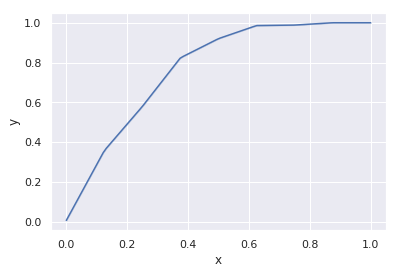

In [4]:

data = dataset()
l = LogisticLearner()
l.fit(data)

display(pd.DataFrame(columns=['Feature', 'Coefficient LogReg'], data=l.coefs))

dist_plot_attr = 'month'
data.infer_domain()
fns = data.rank_fns()

sample = np.linspace(0,1,100)
data_arr = list(map(fns[1][dist_plot_attr], sample))
data_arr.extend(list(map(fns[1][dist_plot_attr], sample)))
data_arr = np.array([np.hstack((sample,sample)), data_arr]).transpose()
df = pd.DataFrame(data=data_arr, columns=['x', 'y'])
ax = sns.lineplot(x='x', y="y",data=df)
display(Markdown("### Distribution of " + dist_plot_attr))
plt.show()

## Cost function?

In [5]:
rs = do_sim(LogisticLearner(exclude_protected=True), collect_incentive_data=False)
display(Markdown("#### Feature averages per group LogReg protected excluded"))
display(rs.feature_table([unprivileged_group, privileged_group]))
#for grp_avg in (rs.results[0].df_new.groupby([group_attr]).mean().reset_index()):
#    samples = np.linspace(min(data.domains[mutable_attr]), max(data.domains[mutable_attr]),50)
#    incentive =

(1000, 49)
Gradient ascend stopepd after  99 iterations (max 100)
(1000, 49)


#### Feature averages per group LogReg protected excluded

,0,1
status,0.21 -> 0.21,0.2 -> 0.2
month,0.28 -> 0.29,0.29 -> 0.29
credit_amount,0.16 -> 0.19,0.19 -> 0.19
savings,1.02 -> 1.05,1.33 -> 1.35
investment_as_income_percentage,2.77 -> 2.7,3.01 -> 3.01
residence_since,2.91 -> 2.56,2.83 -> 2.72
age,0.0 -> 0.0,1.0 -> 1.0
number_of_credits,1.2 -> 1.28,1.44 -> 1.52
people_liable_for,1.04 -> 1.05,1.18 -> 1.21
has_checking_account,1.0 -> 1.0,1.0 -> 1.0


In [6]:
#ax = sns.lineplot(x=mutable_attr, y="incentive",hue=group_attr,data=(rs.
#    _avg_incentive(mutable_attr, group_attr)).reset_index())
#plt.show()

#### distribution pre/post sim for savings

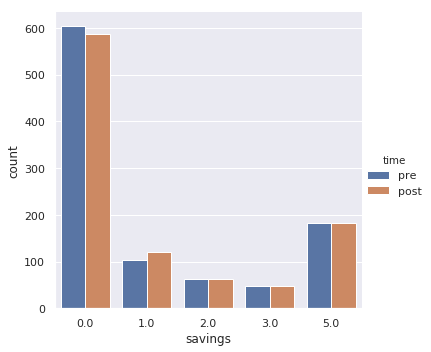

In [7]:
display(Markdown("#### distribution pre/post sim for " + mutable_attr))

def merge_dfs(col, colval1, colval2, df1, df2):
    df1[col] = pd.Series([colval1] * len(df1.index), df1.index)
    df2[col] = pd.Series([colval2] * len(df2.index), df2.index)
    return pd.concat((df1, df2))
merged =merge_dfs('time', 'pre', 'post', rs.results[0].df, rs.results[0].df_new)
sns.catplot(x=mutable_attr, hue="time", kind="count",
            data=merged)
plt.show()

## Comparison of different predictive methods

(1000, 49)
Gradient ascend stopepd after  99 iterations (max 100)
(1000, 49)
(1000, 49)
Gradient ascend stopepd after  99 iterations (max 100)
(1000, 49)
(1000, 49)
Gradient ascend stopepd after  16 iterations (max 100)
(1000, 49)


<Figure size 432x288 with 0 Axes>

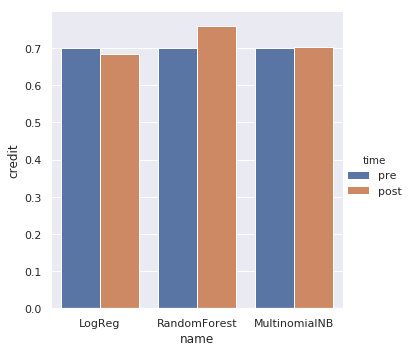

In [8]:
y_attr = 'credit' #mutable_attr # credit_h for prediction, credit for updated ground truth
def extract_avg_ft(rs, ft, name):
    pre_p_mean, _, post_p_mean, _ = rs.feature_average(y_attr, {})
    return [[name, 'pre', pre_p_mean], [name, 'post', post_p_mean]]
plot_data = []

rs = do_sim(LogisticLearner(exclude_protected=True))
plot_data = extract_avg_ft(rs, y_attr, "LogReg")

rs = do_sim(RandomForestLearner())
plot_data += extract_avg_ft(rs, y_attr, "RandomForest")

rs = do_sim(MultinomialNBLearner())
plot_data += extract_avg_ft(rs, y_attr, "MultinomialNB")

plot_data_df = pd.DataFrame(plot_data, columns=["name", "time", y_attr])
plt.figure()
sns.catplot(x="name", y=y_attr, hue="time", kind="bar",
            data=plot_data_df)
plt.show()

## Color-sighted vs. color-blind

(1000, 49)
Gradient ascend stopepd after  89 iterations (max 100)
(1000, 49)
(1000, 49)
Gradient ascend stopepd after  99 iterations (max 100)
(1000, 49)
(1000, 49)
Gradient ascend stopepd after  99 iterations (max 100)
(1000, 49)
(1000, 49)
Gradient ascend stopepd after  99 iterations (max 100)
(1000, 49)
(1000, 49)
Gradient ascend stopepd after  15 iterations (max 100)
(1000, 49)
(1000, 49)
Gradient ascend stopepd after  14 iterations (max 100)
(1000, 49)


<Figure size 432x288 with 0 Axes>

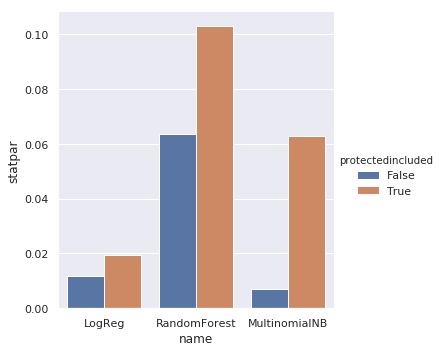

In [9]:

metric_name = "statpar" #gtdiff, mutablediff

def extract_metric(rs, metric_name="statpar", time='post'):
    if metric_name == "statpar":
        ret = rs.stat_parity_diff(unprivileged_group, privileged_group, time=time )
        return ret
    elif metric_name == 'gtdiff':
        gt_label = data.label_names[0]
        pre_p_mean, _, post_p_mean, _ = rs.feature_average(gt_label, privileged_group)
        pre_up_mean, _, post_up_mean, _ = rs.feature_average(gt_label, unprivileged_group)
        return abs(post_p_mean - post_up_mean) if time == 'post' else abs(pre_p_mean - pre_up_mean)
    elif metric_name == 'mutablediff':
        pre_p_mean, _, post_p_mean, _ = rs.feature_average(mutable_attr, privileged_group)
        pre_up_mean, _, post_up_mean, _ = rs.feature_average(mutable_attr, unprivileged_group)
        return abs(post_p_mean - post_up_mean) if time == 'post' else abs(pre_p_mean - pre_up_mean)

    return None


plot_data = []
rs = do_sim(LogisticLearner(exclude_protected=True))
plot_data.append(["LogReg", False, extract_metric(rs, metric_name=metric_name)])

rs = do_sim(LogisticLearner())
plot_data.append(["LogReg", True, extract_metric(rs, metric_name=metric_name)])

rs = do_sim(RandomForestLearner())
plot_data.append(["RandomForest", True, extract_metric(rs, metric_name=metric_name)])

rs = do_sim(RandomForestLearner(exclude_protected=True))
plot_data.append(["RandomForest", False, extract_metric(rs, metric_name=metric_name)])

rs = do_sim(MultinomialNBLearner())
plot_data.append(["MultinomialNB", True, extract_metric(rs, metric_name=metric_name)])

rs = do_sim(MultinomialNBLearner(exclude_protected=True))
plot_data.append(["MultinomialNB", False, extract_metric(rs, metric_name=metric_name)])

plot_data_df = pd.DataFrame(plot_data, columns=["name", "protectedincluded", metric_name])

plt.figure()
sns.catplot(x="name", y=metric_name, hue="protectedincluded", kind="bar",
            data=plot_data_df)
plt.savefig("sighted_comp.png")


# Notions of Fairness

(1000, 49)
Gradient ascend stopepd after  99 iterations (max 100)
(1000, 49)
(1000, 49)
Gradient ascend stopepd after  99 iterations (max 100)
(1000, 49)


<Figure size 432x288 with 0 Axes>

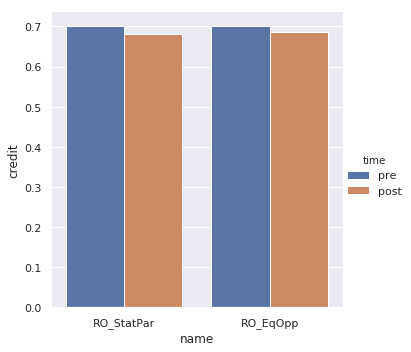

In [10]:

# Compare different notions of fairness
y_attr = 'credit'

rs = do_sim(RejectOptionsLogisticLearner([privileged_group], [unprivileged_group]))
plot_data = extract_avg_ft(rs, mutable_attr, "RO_StatPar")

rs = do_sim(RejectOptionsLogisticLearner([privileged_group], [unprivileged_group], metric_name='Equal opportunity difference'))
plot_data += extract_avg_ft(rs, mutable_attr, "RO_EqOpp")

plot_data_df = pd.DataFrame(plot_data, columns=["name", "time", y_attr])


plt.figure()
sns.catplot(x="name", y=y_attr, hue="time", kind="bar",
            data=plot_data_df)
plt.show()


## Statistical parity comparison

(1000, 49)
Gradient ascend stopepd after  71 iterations (max 100)
(1000, 49)
(1000, 49)
Gradient ascend stopepd after  54 iterations (max 100)
(1000, 49)
(1000, 49)
Gradient ascend stopepd after  99 iterations (max 100)
(1000, 49)


<Figure size 432x288 with 0 Axes>

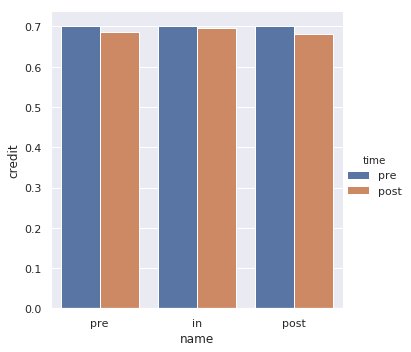

In [11]:

plot_data = []
learners = [("pre", ReweighingLogisticLearner([privileged_group], [unprivileged_group])),
    ("in",FairLearnLearner([privileged_group], [unprivileged_group])),
    ("post",RejectOptionsLogisticLearner([privileged_group], [unprivileged_group]))]

y_attr = mutable_attr
y_attr = 'credit'

for name, l in learners:
    rs = do_sim(l)
    plot_data += extract_avg_ft(rs, mutable_attr, name)

plot_data_df = pd.DataFrame(plot_data, columns=["name", "time", y_attr])

plt.figure()
sns.catplot(x="name", y=y_attr, hue="time", kind="bar",
            data=plot_data_df)
plt.show()

# split for groups
# 1. section 2.1 for cost function
# 2. cost function as distance, only within group (immutable)

## Time of Intervention

(1000, 49)
Gradient ascend stopepd after  42 iterations (max 100)
(1000, 49)
(1000, 49)
Gradient ascend stopepd after  40 iterations (max 100)
(1000, 49)
(1000, 49)
Gradient ascend stopepd after  99 iterations (max 100)
(1000, 49)
(1000, 49)
Gradient ascend stopepd after  49 iterations (max 100)
(1000, 49)
(1000, 49)
Gradient ascend stopepd after  99 iterations (max 100)
(1000, 49)
(1000, 49)
Gradient ascend stopepd after  99 iterations (max 100)
(1000, 49)
(1000, 49)
Gradient ascend stopepd after  99 iterations (max 100)
(1000, 49)
(1000, 49)
Gradient ascend stopepd after  99 iterations (max 100)
(1000, 49)
  index   subsidy   statpar
0   pre  0.000000  0.069370
1   pre  0.333333  0.150246
2   pre  0.666667  0.143377
3   pre  1.000000  0.264836
4  post  0.000000  0.006711
5  post  0.333333  0.090427
6  post  0.666667  0.121523
7  post  1.000000  0.155056


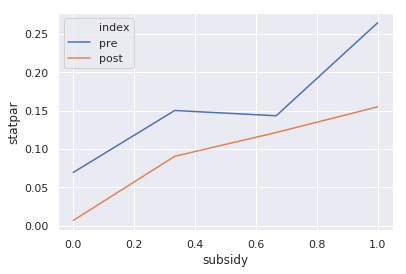

In [12]:

metric_name = 'statpar' # statpar, gtdiff
subsidies = np.linspace(0,1,4)
learner = LogisticLearner(exclude_protected=True)

# creates a instance dependant cost lambda fn
# which reduces cost for unprivileged group by subsidy
def cost_fixed_dependant(subsidy):
    group_attr_ind = data._ft_index(group_attr)
    privileged_val = privileged_group[group_attr]

    return lambda x: cost_fixed(1)[0] if x[group_attr_ind] == privileged_val else cost_fixed(1)[0] - subsidy

result_sets = list(map(lambda s: do_sim(learner, cost_fixed_dep=cost_fixed_dependant(s)), subsidies))
result_sets += list(map(lambda s: do_sim(RejectOptionsLogisticLearner([privileged_group], [unprivileged_group], abs_bound=s)), subsidies))

y_values = list(map(lambda rs: extract_metric(rs, metric_name), result_sets))
index = ['pre'] * len(subsidies) + ['post'] * len(subsidies)
x = np.array([np.hstack((subsidies,subsidies)), y_values]).transpose()

plot_data_df = pd.DataFrame(x, columns=['subsidy', metric_name],index=index).reset_index()
print(plot_data_df)
plt.figure()
ax = sns.lineplot(x='subsidy',hue='index', y=metric_name, data=plot_data_df)
plt.show()

#for rs in result_sets:
#    ax = sns.lineplot(x=mutable_attr, y="incentive",hue=group_attr,data=(rs.                     _avg_incentive(mutable_attr, group_attr)).reset_index())
#    plt.show()